# NCDS Project Notebook

## Packages

In [119]:
import pandas as pd
import pymysql
import logging
import sshtunnel
from sshtunnel import SSHTunnelForwarder
import os.path
import matplotlib.pyplot as plt
import numpy as np
import os 
from collections import Counter
from scipy.stats import gaussian_kde
from pandas import option_context
from IPython.display import display
from PIL import Image

## Open Connection

In [2]:
# You will need to add your SSH public key and database password to connect.
ssh_host = 'vfsmghnecweb01.fsm.northwestern.edu'
ssh_username = 'efa3001'
db_server = 'vfsmghnecdb01.fsm.northwestern.edu'
database_username = 'efa3001'
ssh_pkey = 'C:\\Users\\16262\\Desktop\\NCDS-NEC_Data_Internship\\5-16-privkey-openSSH'
database_password = 'E%H2)h.nPevc<a>&'
database_name = 'nec_dw'
localhost = '127.0.0.1'

In [3]:
def open_ssh_tunnel(verbose=False):
    """Open an SSH tunnel and connect using a username and password.
    
    :param verbose: Set to True to show logging
    :return tunnel: Global SSH tunnel connection
    """
    
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    
    global tunnel
    tunnel = SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_pkey,
        remote_bind_address = (db_server, 3306)
    )
    
    tunnel.start()

def mysql_connect():
    """Connect to a MySQL server using the SSH tunnel connection
    
    :return connection: Global MySQL database connection
    """
    
    global connection
    
    connection = pymysql.connect(
        host = localhost,
        user = database_username,
        passwd = database_password,
        db = database_name,
        port = tunnel.local_bind_port
    )
    
def run_query(sql):
    """Runs a given SQL query via the global database connection.
    
    :param sql: MySQL query
    :return: Pandas dataframe containing results
    """
    
    return pd.read_sql_query(sql, connection)

def mysql_disconnect():
    """Closes the MySQL database connection.
    """
    
    connection.close()
    
def close_ssh_tunnel():
    """Closes the SSH tunnel connection.
    """
    
    tunnel.close

In [4]:
open_ssh_tunnel()
mysql_connect()

## Staff Activities: Relationship between Funding and Success Rating

In [5]:
staff = run_query("SELECT * FROM StaffActivities")
staff_success = staff[staff["ActivityHowSuccessfulID"] > 0.0]

In [6]:
#checking if each staff activity ID is unique...yes!
unique_act = staff_success["ActivityID"].unique()
len(unique_act)==len(staff_success)

True

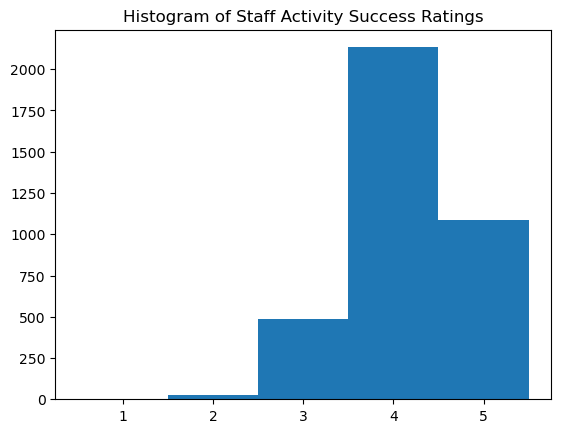

In [7]:
#distribution for success ratings in staff activities
plt.title("Histogram of Staff Activity Success Ratings")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [staff_success["ActivityHowSuccessfulID"]]
my_bins = np.arange(6)+0.5
plt.hist(x, my_bins)
plt.show()

In [8]:
#looking at Activity ID, Success ID, and non-NLM funding
staff_success_funds = staff_success[["ActivityID","ActivityHowSuccessfulID","NonNLMFundingAmount"]]
staff_success_funds.head()

,ActivityID,ActivityHowSuccessfulID,NonNLMFundingAmount
0,9649,4.0,0.0
1,9664,4.0,0.0
2,9665,5.0,0.0
3,9666,5.0,0.0
4,9667,4.0,0.0


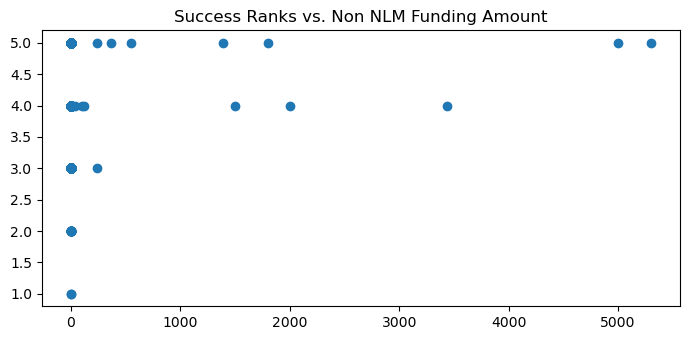

In [9]:
#for success rankings from 0 to 5
plt.title("Success Ranks vs. Non NLM Funding Amount")
plt.scatter(staff_success_funds["NonNLMFundingAmount"], staff_success_funds["ActivityHowSuccessfulID"])

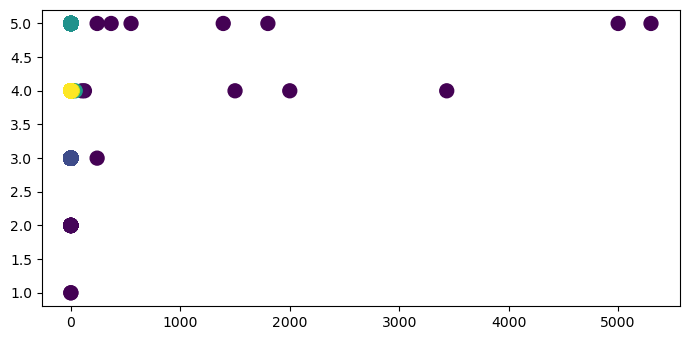

In [11]:
#generate density scatter plot
x = staff_success_funds["NonNLMFundingAmount"]
y = staff_success_funds["ActivityHowSuccessfulID"]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

#darker color = lower density
#lighter color = higher density

In [25]:
staff_describe_fund_success = staff_success_funds.groupby(["ActivityHowSuccessfulID"])["NonNLMFundingAmount"].describe()
staff_describe_fund_success

,count,mean,std,min,25%,50%,75%,max
ActivityHowSuccessfulID,,,,,,,,
1.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2.0,27.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3.0,485.0,0.494845,10.897839,0.0,0.0,0.0,0.0,240.0
4.0,2133.0,3.383029,91.999761,0.0,0.0,0.0,0.0,3434.0
5.0,1087.0,13.477461,232.223901,0.0,0.0,0.0,0.0,5300.0


###### Most of the success ratings are skewed towards 4 or 5. For context, success ratings are determined by the group carrying out the project, so they may be biased. From the density plot and percentiles, it seems that most of the successful (4 or 5 rated) activities have no non-NLM funding. However, the mean and max of nonNLMFundingAmount seem to correlate with how successful the activity is rated. 

## Subaward Activities: Relationship between Mean Activity Funding and Mean Activity Success Rating

In [13]:
#grabbing Subaward Activites, Projects, and Project Funding Tables
sub, sub_proj, sub_proj_fund = run_query("SELECT * FROM SubawardActivities"), run_query("SELECT * FROM Projects"), run_query("SELECT * FROM ProjectFunding")

In [14]:
sub.head(2)

,ActivityID,Title,RegionOfficeID,ProjectID,Description,StartDate,EndDate,Status,ActivityWasConductedOnline,ActivityWasConductedInPerson,...,TrainingWasProvided,AddressStreet,AddressApartmentSuite,AddressCity,AddressState,Zip,116CongressDistrict,GeocodedLatitude,GeocodedLongitude,ModifiedDate
0,9654,All of Us; New York-New Jersey Chapter of the ...,3,9630.0,The purpose of this activity was to present up...,2018-10-24,2018-10-24,Accept and Add Staff Data,0,1,...,0.0,33 West 42nd Street,,New York,NY,10036,None,None,None,2020-03-07
1,9822,2018 Shale & Public Health Conference,3,9687.0,This tabling activity was available from 9am-5...,2018-11-14,2018-11-14,Accept and Add Staff Data,0,1,...,0.0,123 University Place,,Pittsburgh,PA,15260,None,None,None,2020-03-07


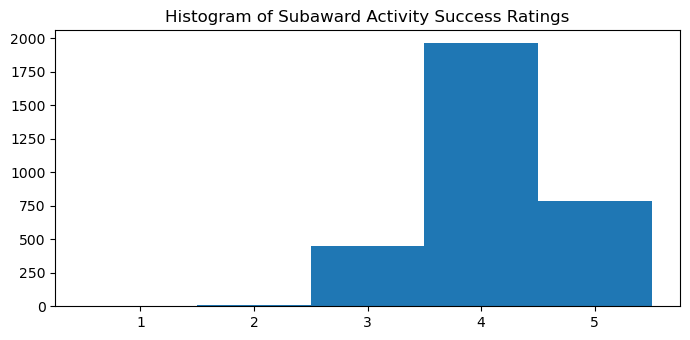

In [15]:
#distribution for success in subaward activities

plt.title("Histogram of Subaward Activity Success Ratings")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [sub["ActivityHowSuccessfulID"]]
my_bins = np.arange(6)+0.5
plt.hist(x, my_bins)
plt.show()

###### The distribution for subaward activity success ratings looks about the same as for the staff award activity success ratings.

In [16]:
#checking if a project has multiple activities...yes!
len(sub["ProjectID"].unique())<len(sub["ProjectID"])

True

In [18]:
#grouping activities to identify mean activity fundings within each project
mean_act_fund = sub_proj_fund.groupby(["ProjectID"])["FundingAmount"].mean().to_frame().rename(columns={"FundingAmount":"MeanFunding"})
proj_title = run_query("SELECT ProjectID, Title, ProjectSummary FROM Projects")
sub_proj_summ_and_fund = mean_act_fund.merge(proj_title, how = "left", on = "ProjectID")
sub_proj_summ_and_fund.head(2)

,ProjectID,MeanFunding,Title,ProjectSummary
0,9630,16070.0,All of Us - The All of Us Research Program and...,The National Institutes of Health and the Nati...
1,9651,4941.0,Seeds of Hope,The Clinton-Essex-Franklin Library System (CEF...


In [20]:
sub_success = run_query("SELECT ActivityID, ProjectID, ActivityHowSuccessfulID FROM SubawardActivities")
sub_success_pos = sub_success[sub_success["ActivityHowSuccessfulID"]>0]
sub_mean_success = sub_success_pos.groupby("ProjectID")["ActivityHowSuccessfulID"].mean().to_frame()
sub_fund_mean_success = sub_mean_success.merge(sub_proj_summ_and_fund, how = "inner", on = "ProjectID")
sub_fund_mean_success.sort_values("MeanFunding", ascending = False).head(3)

,ProjectID,ActivityHowSuccessfulID,MeanFunding,Title,ProjectSummary
416,30397.0,4.000000,261930.0,Citizen Science Month 2021,The Network of the National Library of Medicin...
419,31469.0,3.666667,163993.0,Health and Wellness Conversations at Your Library,StoryCorps and the National Network of Librari...
377,28243.0,4.000000,138805.5,AgriSafeHealthHub (AHH),The purpose of the NLM funded project is to cr...


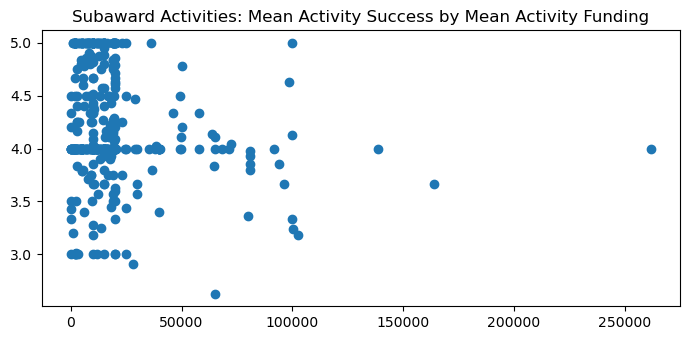

In [23]:
plt.title("Subaward Activities: Mean Activity Success by Mean Activity Funding")
plt.scatter(sub_fund_mean_success["MeanFunding"], sub_fund_mean_success["ActivityHowSuccessfulID"])

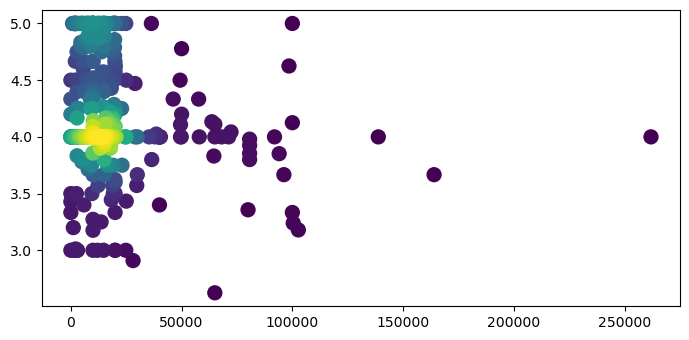

In [24]:
#generate density scatter plot
x1 = sub_fund_mean_success["MeanFunding"]
y1 = sub_fund_mean_success["ActivityHowSuccessfulID"]
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)

idx1 = z1.argsort()
x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

fig1, ax1 = plt.subplots()
ax1.scatter(x1, y1, c=z1, s=100)
plt.show()

#darker color = lower density
#lighter color = higher density

In [27]:
sub_fund_mean_success["RoundedSuccess"] = sub_fund_mean_success["ActivityHowSuccessfulID"].round(0)
sub_describe_fund_success = sub_fund_mean_success.groupby(["RoundedSuccess"])["MeanFunding"].describe()
sub_describe_fund_success

,count,mean,std,min,25%,50%,75%,max
RoundedSuccess,,,,,,,,
3.0,30.0,24519.816667,31782.670793,0.0,2500.00,12821.0,24952.5,102708.5
4.0,280.0,19829.758333,25720.839442,0.0,7975.75,15000.0,19880.5,261930.0
5.0,113.0,13192.044248,13783.880478,750.0,6710.00,10000.0,16127.0,100000.0


###### Similar to staff activities, the subaward activities are concentrated at a success rating of 4.0, on the lower scale of funding. It does not seem like funding has a clear relationship with the success rating of activitiess. Even higher-funded activities at the 100,000 range are spread across the 3 to 5 ratings, and activities above that range are only around the 4 rating.

## Subaward Activities: Relationship between Mean Activity Funding and Descriptors

In [28]:
#top five and lowest five projects in funding (that are not 0)
sub_proj_summ_and_fund.sort_values("MeanFunding", ascending = False)[sub_proj_summ_and_fund["MeanFunding"] > 1]

,ProjectID,MeanFunding,Title,ProjectSummary
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...
3431,1005001,1.498588e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...
4813,1013032,1.484613e+06,NN/LM Pacific NW Region 2016-2021,DESCRIPTION: The mission of the National Netwo...
...,...,...,...,...
4453,1010929,6.600000e+01,Exhibitor: National MS Society Upstate New Yor...,DESCRIPTION: Funds will support The Capital Di...
1322,1002436,6.250000e+01,Exhibit Award: Minnesota-2002 Minnesota 4TH Te...,"DESCRIPTION: Exhibit Award: Lisa McGuire, Jame..."
1451,1002574,5.150000e+01,Exhibit Award - WXII Healthy Living Fair 2004,DESCRIPTION: Exhibit at the WXII Healthy Livin...
1809,1003032,3.750000e+01,Exhibit Award: 2002 American Indian Higher Edu...,DESCRIPTION: Exhibit Award: to exhibit at the ...


### Identifying Unique Descriptors per Funding Bin

In [72]:
sub_proj_unique = sub_proj_summ_and_fund
sub_proj_unique.sort_values("MeanFunding").head()

,ProjectID,MeanFunding,Title,ProjectSummary,ShortSum
5302,1016866,0.0,Partner Outreach 2018-2019: University of Illi...,DESCRIPTION: As part of the Professional Servi...,"As part Professional Services Agreement, Contr..."
5209,1016306,0.0,Partner Outreach 2018-2021: University of Nort...,DESCRIPTION: To perform outreach on behalf of ...,perform behalf GMR
1079,1002179,0.0,Houston AIDS Information Link (HAIL) 1998,DESCRIPTION: The Houston AIDS Information Link...,"Houston AIDS Link collaborative patients, affe..."
5210,1016307,0.0,Partner Outreach 2018-2021: University of Cinc...,DESCRIPTION: To perform outreach on behalf of ...,perform behalf GMR
5298,1016848,0.0,All of Us; OU Tulsa Library Individualized Hea...,DESCRIPTION: The University of Oklahoma Tulsa-...,Oklahoma Tulsa- Schusterman designated countie...


In [35]:
#Removing most common words overall
common_words_list = Counter(" ".join(sub_proj_unique['ProjectSummary']).split()).most_common(250)
special_words = ['library,','*','I','Library,']
filler_words = [tupleObj[0] for tupleObj in common_words_list]
filler_words.extend(special_words)
print(filler_words)

['and', 'the', 'to', 'of', 'will', 'in', 'health', 'a', 'for', 'The', 'DESCRIPTION:', 'information', 'with', 'be', 'on', 'is', 'Health', 'Library', 'at', 'as', 'project', 'by', 'resources', 'that', 'their', 'access', 'provide', 'training', 'community', 'library', 'this', 'n', 'public', 'REMARKS:', 'an', 'This', 'are', 'use', 'from', 'NLM', 'other', 'URL:', 'staff', 'PIEmailAddress:', 'PITelephone:', 'outreach', 'Training:', 'PIFirstName:', 'PILastName:', 'support', 'University', 'AwardType:', 'about', 'through', 'services', 'our', 'Medical', 'program', 'or', 'National', 'education', 'students', 'literacy', 'care', 'Medicine', 'medical', 'Center', 'have', 'awareness', 'libraries', 'award', 'online', 'how', 'Public', 'who', 'improve', 'promote', 'librarians', 'providing', 'also', 'professionals', 'available', 'can', '-', 'research', 'which', 'Outreach', 'has', 'goal', 'increase', 'develop', 'data', 'local', 'these', 'members', 'All', 'Information', 'In', 'well', 'Project', 'using', 'Comm

In [37]:
#source: https://stackoverflow.com/questions/55533962/removing-specific-word-in-a-string-in-pandas
filler_words = set(filler_words)
drop = lambda x: ' '.join(w for w in x.split() if not w in filler_words)
sub_proj_unique['ShortSum'] = sub_proj_unique['ProjectSummary'].apply(drop)
sub_proj_unique.sort_values("MeanFunding", ascending = False).head(3)

,ProjectID,MeanFunding,Title,ProjectSummary,ShortSum
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...,"As largest healthcare, senior adults often lef..."
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...,Maryland Human Services Regional 2006-2011 con...
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...,Gibson D. Lewis North Texas (UNTHSC) Regional ...


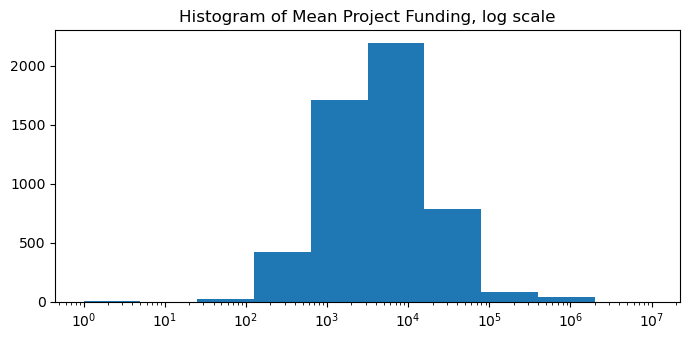

In [80]:
#create histogram to determine funding bins.
#source: https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(1),np.log10(10000000),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

plt.title("Histogram of Mean Project Funding, log scale")
x = [sub_proj_unique['MeanFunding']]

plot_loghist(x, 10)

In [90]:
#bins to sort the data into
funding_bins=(np.arange(11)+1)**6
print(funding_bins)

#note: mean funds of 1 and 0 will be grouped, 1 being most likely an error or null value.
sub_proj_unique[sub_proj_unique['MeanFunding']==1].head(3)

[      1      64     729    4096   15625   46656  117649  262144  531441
 1000000 1771561]


,ProjectID,MeanFunding,Title,ProjectSummary,ShortSum
2826,1004249,1.0,PSR Outreach Connections,"DESCRIPTION: This project highlights training,...","highlights training, demonstrations presentati..."
2887,1004325,1.0,Improving Access to HIV/AIDS Health Informatio...,DESCRIPTION: The goal of the STAR TRACK progra...,STAR TRACK prevent spread educating youth betw...
2893,1004332,1.0,Improving HIV/AIDS Health Information Use and ...,DESCRIPTION: The goal of the SHINE (Statewide ...,SHINE (Statewide Network) affected communities...


In [92]:
def to_the_bin(num):
    """
    to assign a bin value for the number up to largest number in funding_bins.
    
    Arguments: a number, int or float
    
    Returns: bin value containing the number, upper bound. however, nums from 0 to (and including) 1 will be in the bin 0.
    
    """
    cap = 0
    count = 0
    for y in funding_bins:
        count+=1
        if (num > y):
            cap = funding_bins[count]
    return cap

In [93]:
sub_proj_unique["FundingBin"] = sub_proj_unique["MeanFunding"].apply(to_the_bin)

In [94]:
descr_fund_bins = sub_proj_unique.groupby(['FundingBin'])["MeanFunding"].describe()
descr_fund_bins

,count,mean,std,min,25%,50%,75%,max
FundingBin,,,,,,,,
0,62.0,1.129032e-01,0.319058,0.000000e+00,0.000,0.000000e+00,0.000000e+00,1.000000e+00
64,4.0,4.525000e+01,14.660036,2.950000e+01,35.500,4.450000e+01,5.425000e+01,6.250000e+01
729,485.0,4.157662e+02,168.874977,6.600000e+01,250.000,4.640000e+02,5.090000e+02,7.285000e+02
4096,1809.0,1.813337e+03,774.409800,7.340000e+02,1222.000,1.655000e+03,2.099000e+03,4.092000e+03
15625,2045.0,8.688366e+03,3719.139004,4.100000e+03,5000.000,7.790600e+03,1.200000e+04,1.551000e+04
46656,650.0,2.529321e+04,7971.391504,1.567200e+04,19727.000,2.334650e+04,2.933388e+04,4.650000e+04
117649,193.0,6.818111e+04,20169.251997,4.674600e+04,50000.000,6.000000e+04,8.071000e+04,1.176114e+05
262144,22.0,1.699865e+05,43965.949721,1.178367e+05,138448.875,1.610902e+05,1.954642e+05,2.619300e+05
531441,8.0,3.467877e+05,58584.054094,2.899380e+05,313302.500,3.252300e+05,3.582310e+05,4.646757e+05


In [95]:
def key_words(df, col):
    """
    joins the specified (col) column cells for each group, 
    and identifies the five most common words in that group.
    
    to use: df.groupby(...).apply(common_word, col = '...')
    
    arguments: pd dataframe, string column name
    
    returns: a list of tuples of the five most common words 
    for this group and their counts.
    """
    common_list = Counter(" ".join(df[col]).split()).most_common(5)
    return (common_list)

In [108]:
unique_words = sub_proj_unique.groupby(['FundingBin']).apply(key_words, col = 'ShortSum').to_frame()
unique_words.rename(columns={unique_words.columns[0]:'SummaryKeyWords'}, inplace=True)

title_words = sub_proj_unique.groupby(['FundingBin']).apply(key_words, col = 'Title').to_frame()
title_words.rename(columns={title_words.columns[0]:'TitleKeyWords'}, inplace=True)


In [113]:
keys_count = unique_words.merge(descr_fund_bins, how = "left", on = "FundingBin").merge(title_words, how = "left", on = "FundingBin")[["SummaryKeyWords", "TitleKeyWords","count"]].rename(columns = {"count":"NumberProjects"})

pd.set_option("max_colwidth", None)
keys_count 

,SummaryKeyWords,TitleKeyWords,NumberProjects
FundingBin,,,
0,"[(behalf, 37), (offering, 25), (promotion, 25), (Serve, 24), (GMR., 24)]","[(Library, 42), (of, 41), (Outreach, 40), (University, 32), (Partner, 25)]",62.0
64,"[(Wallace, 2), (ProfessionalTargetPopHPStudents:, 2), (Award:, 2), (Winston-Salem,, 2), (Addajane, 1)]","[(Exhibit, 3), (Award, 2), (-, 2), (Award:, 2), (Professional, 1)]",4.0
729,"[(ProfessionalTargetPopPharm:n, 71), (ProfessionalTargetPopHPStudents:, 62), (Conference, 44), (Electronic, 43), (meeting, 42)]","[(-, 259), (Award, 186), (Exhibit, 117), (Professional, 104), (Health, 90)]",485.0
4096,"[(NIH, 149), (Award:, 134), (October, 133), (Conference, 127), (meeting, 93)]","[(-, 857), (Award, 671), (Health, 492), (Library, 430), (of, 395)]",1809.0
15625,"[(mobile, 136), (databases., 126), (databases, 126), (primary, 125), (minority, 120)]","[(Health, 974), (and, 479), (Library, 473), (Outreach, 469), (-, 462)]",2045.0
46656,"[(management, 69), (build, 64), (Access, 63), (digital, 63), (series, 62)]","[(Health, 318), (and, 160), (Information, 147), (for, 141), (to, 115)]",650.0
117649,"[(biomedical, 44), (Resource, 40), (AIDS, 37), (HIV, 35), (network, 30)]","[(Health, 72), (of, 48), (Information, 41), (Community, 33), (Project, 33)]",193.0
262144,"[(MCR, 10), (Engagement, 7), (game, 6), (practices, 5), (AgriSafe, 5)]","[(Health, 11), (of, 9), (Library, 6), (Information, 5), (Public, 4)]",22.0
531441,"[(evaluation, 16), (NEO, 9), (RML, 6), ((Aim, 5), (members., 4)]","[(Center, 4), (Outreach, 3), (Evaluation, 3), (-, 2), (National, 2)]",8.0


In [114]:
pd.reset_option('display.max_colwidth')

### Unique Problems/Barriers Per Funding Bin

In [126]:
rep = run_query("SELECT * FROM Reports")[["ProjectID","ProblemsOrBarriersEncountered"]]
rep_bar = rep[rep.ProblemsOrBarriersEncountered.astype(bool)]
bar_and_fund = rep_bar.merge(mean_act_fund, how = "inner", on = "ProjectID")
bar_and_fund.head()

,ProjectID,ProblemsOrBarriersEncountered,MeanFunding
0,17166,<p>OHAI only discovered two major barriers or problems surrounding the programming. Â The initial issue was the recruitment of disaster preparedness/response and emergency staff to provide the Agi...,5000.0
1,17139,"<p>Our public health and health sciences librarians created engaging content to promote health literacy, however, the primary problem we had was attendance for our health information classes. This...",96184.0
2,17136,"<p>A limited number of staff working on the NNLM All of Us Community Engagement Ambassador Program was a barrier that was faced in pursuing project objectives. Due to a limited number of staff, Sh...",98483.0
3,17060,<p>This did not apply to my professional development award.</p>\n,1500.0
4,17057,<p>This did not apply to my professional development award.</p>\n,1500.0


In [129]:
def common_list (dfcol, n):
    """
    identifies the most common n words in the entire column
    
    """
    comlist = Counter(" ".join(dfcol).split()).most_common(n)
    comlist = [tupleObj[0] for tupleObj in comlist]
    return (comlist)

def drop_words(text, comlist):
    """
    removes comlist words from the string of interest
    
    """
    to_drop = set(comlist)
    return (' '.join(w for w in text.split() if not w in to_drop))

In [141]:
bar_and_fund["FundingBin"] = bar_and_fund["MeanFunding"].apply(to_the_bin)
com_barriers = common_list(bar_and_fund['ProblemsOrBarriersEncountered'], 100)
bar_and_fund['ShortProblem'] = bar_and_fund['ProblemsOrBarriersEncountered'].apply(drop_words, comlist = com_barriers)
unique_bar = bar_and_fund.groupby(['FundingBin']).apply(key_words, col = 'ShortProblem').to_frame()
unique_bar = unique_bar.merge(bar_and_fund.groupby(['FundingBin']).count()['ProjectID'], on = 'FundingBin').rename(columns={0:'KeyBarriers', 'ProjectID':'NumProjs'})

In [142]:
unique_bar

,KeyBarriers,NumProjs
FundingBin,,
0,"[(year, 9), (materials, 9), (librarians, 8), (them, 7), (librarian, 7)]",16
729,"[(what, 3), (check, 3), (far, 3), (them, 3), (my, 3)]",10
4096,"[(virtual, 22), (materials, 20), (made, 20), (do, 19), (local, 19)]",110
15625,"[(us, 48), (libraries, 45), (because, 45), (them, 45), (major, 44)]",224
46656,"[(sessions, 38), (each, 35), (first, 32), (school, 29), (libraries, 29)]",113
117649,"[(challenges, 24), (All, 20), (Us, 19), (challenge, 17), (programming, 16)]",31
262144,"[(UCM, 3), (fully, 2), (both, 2), (Regional, 2), (2020., 2)]",2


## Subaward Activities: Zip Codes and Mean Activity Funding

In [118]:
sub_geog = sub[['ActivityID', 'Title', 'ProjectID','Zip', 'County', 'AddressState', 'StartDate', 'EndDate']]
proj_occurr = pd.DataFrame(sub['ProjectID'].value_counts())
proj_occurr.reset_index(inplace=True)
proj_occurr = proj_occurr.rename(columns = {'index':'ProjectID', 'ProjectID': 'ActivityCount'})
sub_geog = sub_geog.merge(proj_occurr, on = 'ProjectID')
sub_geog['ProjectID'] = sub_geog['ProjectID'].astype('int64').astype('object')

total_proj_funding = sub_proj_fund.groupby('ProjectID').sum()['FundingAmount']
sub_geog = sub_geog.merge(total_proj_funding, on = 'ProjectID').rename(columns={'FundingAmount':'TotalProjFund'})

#"ApproxFunding" is the mean activity fund by project
sub_geog['ApproxFunding'] = sub_geog['TotalProjFund']/sub_geog['ActivityCount']
sub_geog.head(3)

,ActivityID,Title,ProjectID,Zip,County,AddressState,StartDate,EndDate,ActivityCount,TotalProjFund,ApproxFunding
0,9654,All of Us; New York-New Jersey Chapter of the ...,9630,10036,New York,NY,2018-10-24,2018-10-24,3,16070.0,5356.666667
1,11918,All of Us; The All of Us Research Program and ...,9630,12207,Albany,NY,2019-02-26,2019-02-26,3,16070.0,5356.666667
2,16342,All of Us; The All of Us Research Program and ...,9630,14604,Monroe,NY,2018-11-07,2018-11-07,3,16070.0,5356.666667


In [117]:
#to create a file for Tableau visualizations

# file_path = "C:\\Users\\16262\\Desktop\\ncds"

# if not os.path.exists(file_path):
#      os.mkdir(file_path)

# output_file = 'NNLM_SubawardActivities_and_Zip.tsv'
# complete_fn = os.path.join(file_path, output_file)
# sub_geog_df.to_csv(complete_fn, sep = '\t',index=False)

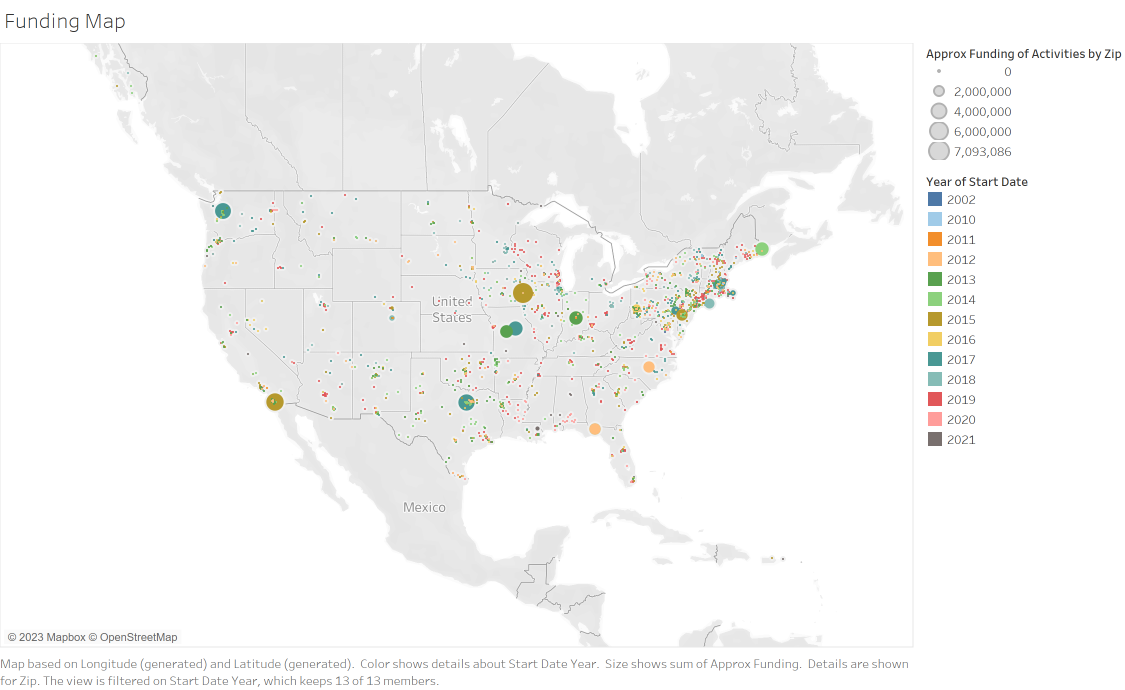

In [124]:
path="C:/Users/16262/Desktop/ncds/Funding_Map.png"
display(Image.open(path))

## Close Connection

In [ ]:
mysql_disconnect()
close_ssh_tunnel()